In [10]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import calculate_relative_presentation

### Parameters

In [12]:
iteration = 0
PhenoGraph_k = 100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical Subtype': 'TNBC'
}

### Load Gram matrix and clinical data

#### Discovery

In [13]:
if iteration == 0:
    SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
else:
    SoftWL_dict= pickle.load(
        open(
            os.path.join(
                PROJECT_ROOT,
                "Output",
                "b_Soft_WL_Kernel_random_split",
                "Danenberg",
                "Subset_1",
                "SoftWL_dict_iter_"
                + str(iteration)
                + "_PhenoGraph_k_"
                + str(PhenoGraph_k)
                + "_"
                + node_label
                + ".pkl",
            ),
            "rb",
        ),
    )
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


#### Inner-validation

In [14]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]
Clinical_subtype_cohort2 = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_cohort2]) 
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

200 patients are included


#### External validation

In [15]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical_jackson = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical_jackson = process_Jackson_clinical_data(clinical_jackson)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical_jackson.loc[clinical_jackson["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical_jackson.loc[clinical_jackson["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]


### Community detection

In [16]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

In [17]:
SoftWL_dict= pickle.load(
        open(
            os.path.join(
                PROJECT_ROOT,
                "Output",
                "b_Soft_WL_Kernel_random_split",
                "Danenberg",
                "Subset_1",
                "SoftWL_dict_iter_"
                + str(2)
                + "_PhenoGraph_k_"
                + str(PhenoGraph_k)
                + "_"
                + node_label
                + ".pkl",
            ),
            "rb",
        ),
    )
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix_softwl = SoftWL_dict["Gram_matrix"]
G_population = construct_PopulationGraph(
    Gram_matrix_softwl,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids_softwl = detect_communities(G_population, size_smallest_cluster, resolution = 1)

In [18]:
for i in np.unique(Community_ids_softwl):
    print("Community {} has {} patients".format(i, np.sum(Community_ids_softwl == i)))
for i in np.unique(Community_ids):
    print("Community {} has {} patients".format(i, np.sum(Community_ids == i)))

Community 1.0 has 97 patients
Community 2.0 has 73 patients
Community 3.0 has 61 patients
Community 4.0 has 51 patients
Community 5.0 has 48 patients
Community 6.0 has 26 patients
Community 7.0 has 23 patients
Community 1.0 has 96 patients
Community 2.0 has 90 patients
Community 3.0 has 48 patients
Community 4.0 has 46 patients
Community 5.0 has 45 patients
Community 6.0 has 32 patients
Community 7.0 has 22 patients


In [20]:
def IoU(set1, set2):
    return len(set1.intersection(set2))/len(set1.union(set2))
for i in np.unique(Community_ids_softwl):
    for j in np.unique(Community_ids):
        print("IoU between communities {} and {} is {}".format(i, j, IoU(set(np.where(Community_ids_softwl == i)[0]), set(np.where(Community_ids == j)[0]))))


IoU between communities 1.0 and 1.0 is 0.07222222222222222
IoU between communities 1.0 and 2.0 is 0.016304347826086956
IoU between communities 1.0 and 3.0 is 0.29464285714285715
IoU between communities 1.0 and 4.0 is 0.036231884057971016
IoU between communities 1.0 and 5.0 is 0.43434343434343436
IoU between communities 1.0 and 6.0 is 0.0
IoU between communities 1.0 and 7.0 is 0.0
IoU between communities 2.0 and 1.0 is 0.4444444444444444
IoU between communities 2.0 and 2.0 is 0.08666666666666667
IoU between communities 2.0 and 3.0 is 0.03418803418803419
IoU between communities 2.0 and 4.0 is 0.017094017094017096
IoU between communities 2.0 and 5.0 is 0.008547008547008548
IoU between communities 2.0 and 6.0 is 0.009615384615384616
IoU between communities 2.0 and 7.0 is 0.0
IoU between communities 3.0 and 1.0 is 0.039735099337748346
IoU between communities 3.0 and 2.0 is 0.4803921568627451
IoU between communities 3.0 and 3.0 is 0.04807692307692308
IoU between communities 3.0 and 4.0 is 0.

#### Survival analysis for subgroups

In [12]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i,  'Clinical Subtype'].values[0] for i in Patient_IDs])
print(np.unique(Clinical_subtype))
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1


for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

['HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC' 'nan']
379 patients are included
S1 (N = 22):
Survival: hr = 2.84598995663616, p = 0.00015705436064041058
	Significant
S2 (N = 32):
Survival: hr = 1.3877096300133853, p = 0.2631159690166793
S3 (N = 90):
Survival: hr = 1.0594489166804626, p = 0.7758611635406484
S4 (N = 96):
Survival: hr = 0.9554774872262873, p = 0.8237019511367308
S5 (N = 46):
Survival: hr = 0.8086069903515286, p = 0.48479928833711305
S6 (N = 48):
Survival: hr = 0.6797470605299714, p = 0.2032335319785332
S7 (N = 45):
Survival: hr = 0.6360346152067979, p = 0.15143859454205688


#### Inter-patient similarities

In [13]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids_ == i, :][:, Subgroup_ids_ == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

22 subgroup 1 patients, averaged Intra-group similarity is 0.82 
32 subgroup 2 patients, averaged Intra-group similarity is 0.70 
90 subgroup 3 patients, averaged Intra-group similarity is 0.44 
96 subgroup 4 patients, averaged Intra-group similarity is 0.48 
46 subgroup 5 patients, averaged Intra-group similarity is 0.77 
48 subgroup 6 patients, averaged Intra-group similarity is 0.63 
45 subgroup 7 patients, averaged Intra-group similarity is 0.82 
Overall 379 patients, averaged Intra-group similarity is 0.33 


#### Plot population graph

[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


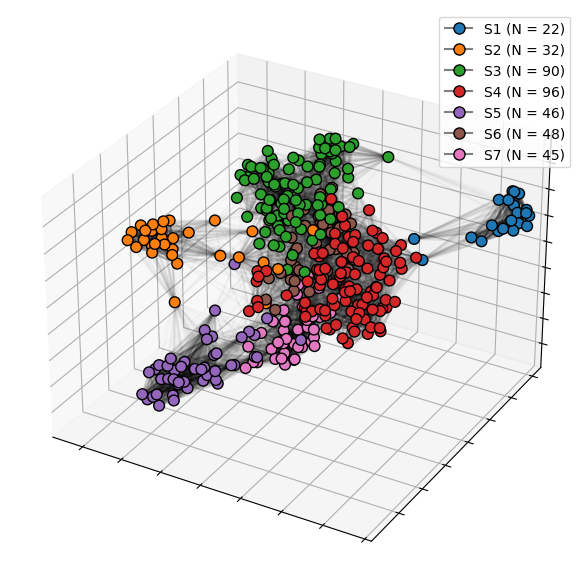

In [26]:
# from mayavi import mlab
G_population = construct_PopulationGraph(
    Gram_matrix,
    "two_step_knn_graph",
    para_dict={"weight_threshold_percentile": 90, "knn_k": 20},
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(
    G_population, seed=3, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
fig = plt.figure(figsize=(6,6), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[int(i)] for i in Subgroup_ids_],
    # c= 'white',
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for i in range(1, len(HR)+1):
    handles.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor = color_palette[i],
        label="S{} (N = {})".format(i, np.sum(Subgroup_ids_ == i)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ))
   
ax.legend(handles=handles, fontsize = 10)

# ax.view_init(30, 0)
# ax.set_axis_off()
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
# ax.set(xlabel="x", ylabel="y", zlabel="z")


#### Plot hazard ratio

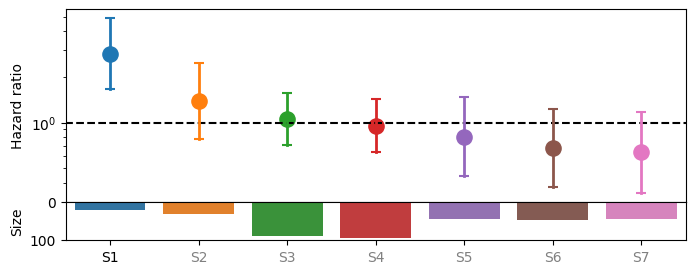

In [15]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

#### Plot K-M Plot

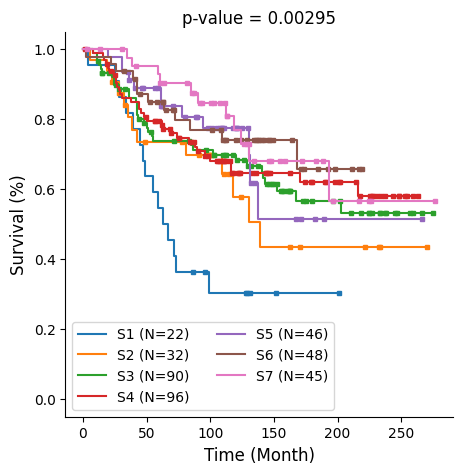

In [16]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Find overpresented patterns

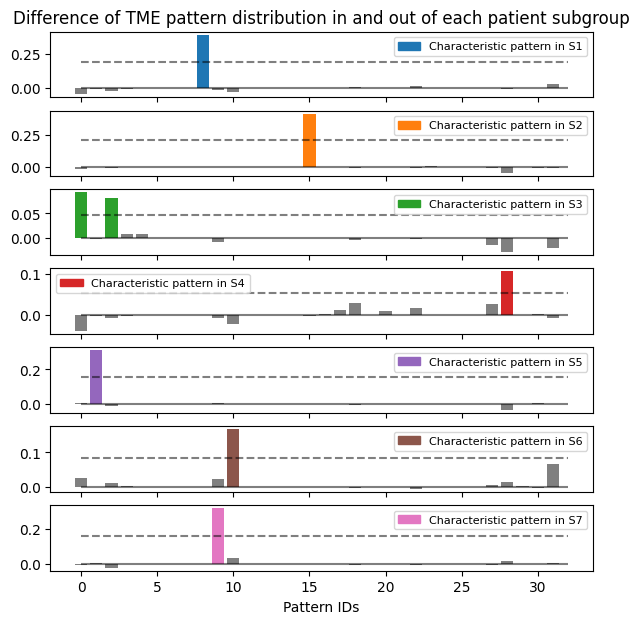

In [17]:
def hodges_lehmann_estimator(x, y):
    """
    Compute the Hodges-Lehmann estimator for the median difference between two samples.

    Parameters:
    - x: numpy array, first sample
    - y: numpy array, second sample

    Returns:
    - Hodges-Lehmann estimator
    """
    n = len(x)
    m = len(y)
    hl_estimates = []

    for i in range(n):
        for j in range(m):
            hl_estimates.append((x[i] - y[j]))

    return np.median(hl_estimates)


Overpresented_patterns = {}
import scipy.stats as stats

f, ax = plt.subplots(7, 1, figsize=(7, 7), sharex=True)
for subgroup_id in [1, 2, 3, 4, 5, 6, 7]:
    Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
    Histogram_other_group = Histograms_[Subgroup_ids_ != subgroup_id]
    Hodges_lehmann = []
    P_value = []
    for pattern_id in range(Histograms_.shape[1]):
        histogram_intra_group = Histogram_intra_group[:, pattern_id]
        histogram_other_group = Histogram_other_group[:, pattern_id]
        test_result = stats.mannwhitneyu(
            histogram_intra_group, histogram_other_group, alternative="greater"
        )
        P_value.append(test_result.pvalue)
        hodges_lehmann = hodges_lehmann_estimator(
            histogram_intra_group, histogram_other_group
        )
        Hodges_lehmann.append(hodges_lehmann)
    Hodges_lehmann = np.array(Hodges_lehmann)
    P_value = np.array(P_value)

    # Index = np.argsort(Hodges_lehmann)
    Index = np.arange(len(Hodges_lehmann))
    DF = pd.DataFrame(
        {
            "Hodges-Lehmann": Hodges_lehmann[Index],
            "P_value": P_value[Index] < 0.05,
            "Overpresented": Hodges_lehmann[Index] > 0.5 * np.max(Hodges_lehmann),
        }
    )
    ax[subgroup_id - 1].bar(
        range(len(Hodges_lehmann)),
        DF["Hodges-Lehmann"],
        color=DF["Overpresented"].map(
            {True: color_palette[subgroup_id - 1], False: "grey"}
        ),
    )
    import matplotlib.patches as patches

    handles = [
        patches.Rectangle(
            (0.6, 0.3),
            1,
            1,
            edgecolor=color_palette[subgroup_id - 1],
            facecolor=color_palette[subgroup_id - 1],
            label="Characteristic pattern in S{}".format(subgroup_id),
        ),
        # Line2D([0], [0], linestyle="--", color="k", label="Threshold"),
    ]

    ax[subgroup_id - 1].legend(handles=handles, fontsize=8)
   
    ax[subgroup_id - 1].set_ylabel("", fontsize=10)
    ax[subgroup_id - 1].hlines(
        0.5 * np.max(Hodges_lehmann), 0, len(Hodges_lehmann), color="k", linestyle="--", alpha = 0.5
    )
    ax[subgroup_id - 1].hlines(0, 0, len(Hodges_lehmann), color="k", alpha = 0.5)
    
# ax[6].set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])
# ax[6].set_xticklabels(
#     [i for i in range(1, len(Hodges_lehmann) + 1)], fontsize=10, rotation=90
# )
ax[0].set(title = "Difference of TME pattern distribution in and out of each patient subgroup")
ax[6].set_xlabel("Pattern IDs", fontsize=10)

plt.show()

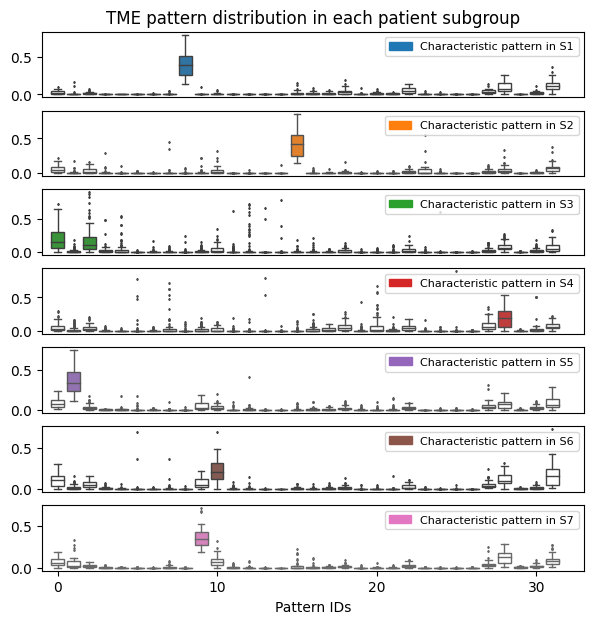

In [20]:
Overpresented_patterns = {}
f, ax = plt.subplots(7, 1, figsize=(7,7), sharex=True)
for subgroup_id in [1, 2, 3, 4, 5, 6, 7]:
    DF_proportion = pd.DataFrame({})
    Hodges_lehmann = []
    Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
    for pattern_id in range(Histograms_.shape[1]):
        histogram_intra_group = Histogram_intra_group[:, pattern_id]
        histogram_other_group = Histogram_other_group[:, pattern_id]
        test_result = stats.mannwhitneyu(
            histogram_intra_group, histogram_other_group, alternative="greater"
        )
        hodges_lehmann = hodges_lehmann_estimator(
            histogram_intra_group, histogram_other_group
        )
        Hodges_lehmann.append(hodges_lehmann)
        DF_proportion = pd.concat(
            [
                DF_proportion,
                pd.DataFrame(
                    {
                        "Pattern_id": [pattern_id + 1] * len(histogram_intra_group),
                        "Proportion": histogram_intra_group,
                        "Hodges_lehmann": [hodges_lehmann] * len(histogram_intra_group),
                    }
                ),
            ]
        )
    DF_proportion["Characteristic"] = DF_proportion["Hodges_lehmann"] > 0.5 * np.max(
        Hodges_lehmann
    )
    Overpresented_patterns[subgroup_id] = list(np.unique(DF_proportion.loc[
        DF_proportion["Characteristic"], "Pattern_id"].values))
    sns.boxplot(
        data=DF_proportion,
        x="Pattern_id",
        y="Proportion",
        ax=ax[subgroup_id - 1],
        hue="Characteristic",
        showfliers=True,
        fliersize=1,
        palette={True: color_palette[subgroup_id - 1], False: "white"},
        dodge =False,
        linewidth=1,
        # width=1.5,
        
    )
    # ax.boxplot(
    handles = [
        patches.Rectangle(
            (0.6, 0.3),
            1,
            1,
            edgecolor=color_palette[subgroup_id - 1],
            facecolor=color_palette[subgroup_id - 1],
            label="Characteristic pattern in S{}".format(subgroup_id),
        ),
        # Line2D([0], [0], linestyle="--", color="k", label="Threshold"),
    ]
    ax[subgroup_id - 1].legend(handles=handles, fontsize=8, loc = 'upper right')

    # )
    Hodges_lehmann = np.array(Hodges_lehmann)
    # ax[subgroup_id - 1].plot(
    #     range(len(Hodges_lehmann)),
    #     Hodges_lehmann,
    #     color='k',
    #     linewidth=1,
    #     linestyle="--",
    #     marker = 'o',
    #     markersize = 1,

    # )

    ax[subgroup_id - 1].set_ylabel("", fontsize=8)
    ax[subgroup_id - 1].get_xaxis().set_visible(False)
    ax[subgroup_id - 1].set(xlim = (-1, 33))
    
    # ax[subgroup_id - 1].legend(handles = [])
ax[0].set_title("TME pattern distribution in each patient subgroup".format(subgroup_id))
ax[6].get_xaxis().set_visible(True)
ax[6].set_xlabel("Pattern IDs", fontsize=10)
ax[6].set(
    xticks = [0,10,20,30],
    xticklabels = [0,10,20,30],
)
# ax[6].set_xticklabels(
#     [i for i in range(1, len(Hodges_lehmann) + 1)], fontsize=8, rotation=90
# )
# ax[0].set_title("Characteristic TME patterns in each subgroup", fontsize = 12)
ax[6].set_xlabel("Pattern IDs", fontsize=10)

plt.show()

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


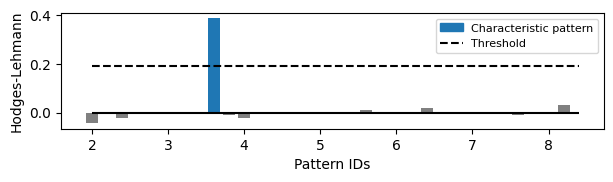

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:7.679e-23 U_stat=7.848e+03


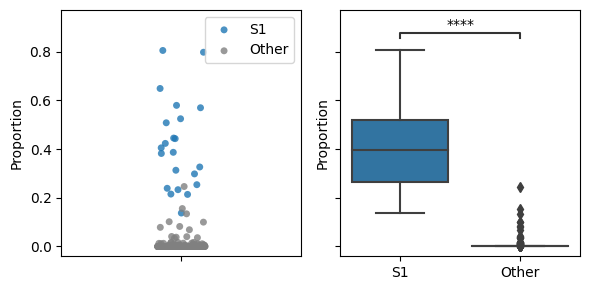

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


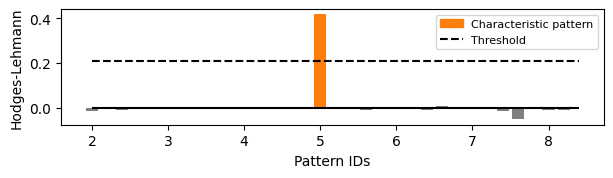

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:5.554e-22 U_stat=1.109e+04


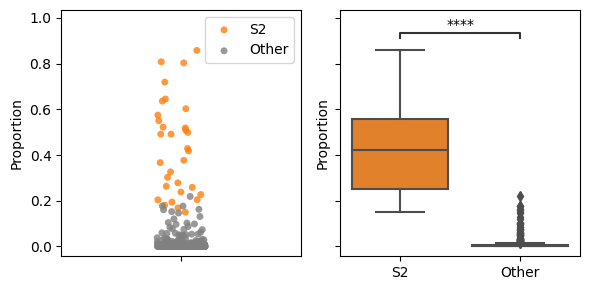

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


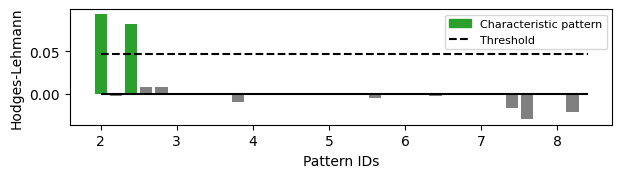

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:3.403e-12 U_stat=1.932e+04


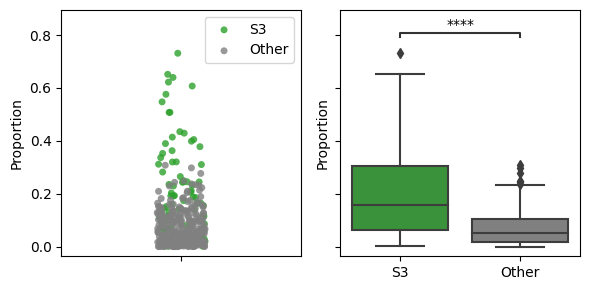

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:1.131e-19 U_stat=2.124e+04


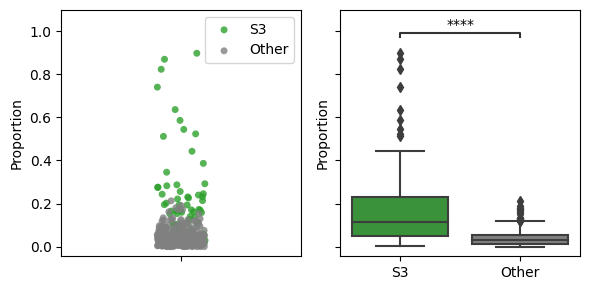

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


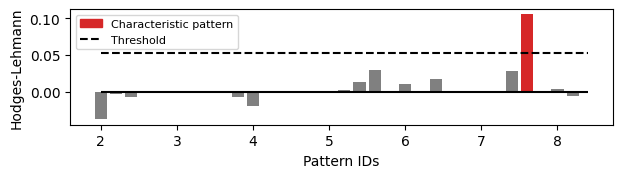

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:2.158e-10 U_stat=1.947e+04


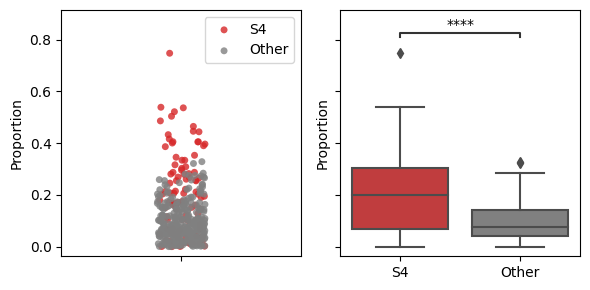

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


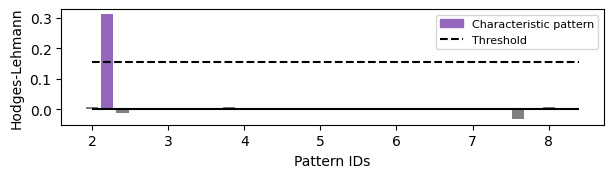

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:5.899e-28 U_stat=1.523e+04


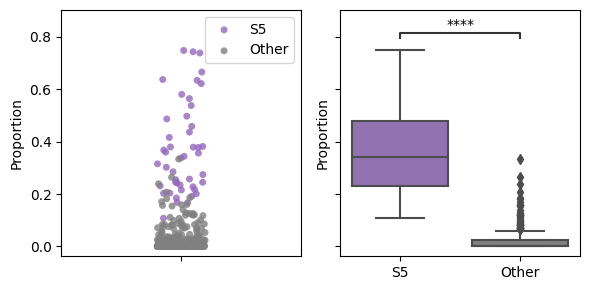

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


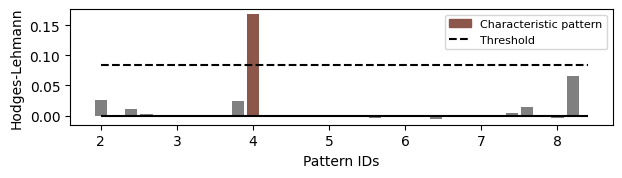

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:6.435e-16 U_stat=1.367e+04


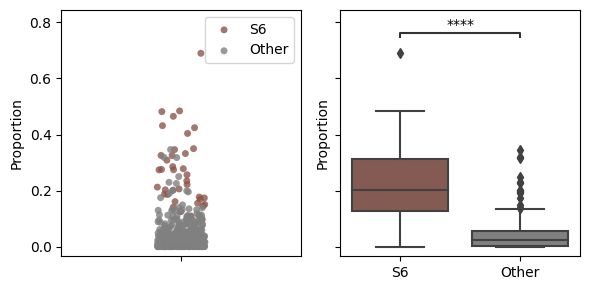

/tmp/ipykernel_749814/3109984649.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])


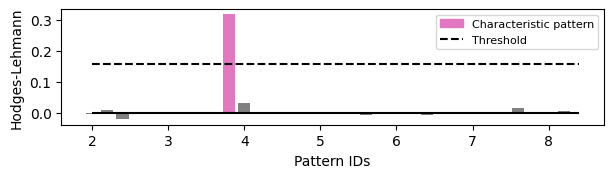

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:6.226e-28 U_stat=1.502e+04


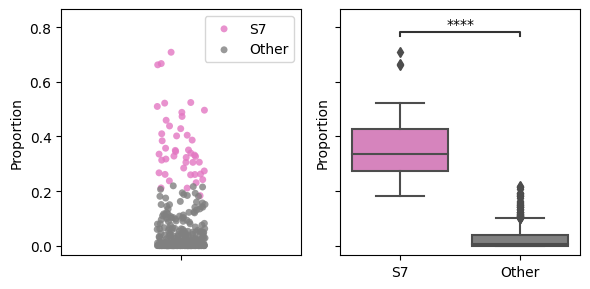

In [21]:
def hodges_lehmann_estimator(x, y):
    """
    Compute the Hodges-Lehmann estimator for the median difference between two samples.

    Parameters:
    - x: numpy array, first sample
    - y: numpy array, second sample

    Returns:
    - Hodges-Lehmann estimator
    """
    n = len(x)
    m = len(y)
    hl_estimates = []

    for i in range(n):
        for j in range(m):
            hl_estimates.append((x[i] - y[j]))

    return np.median(hl_estimates)


Overpresented_patterns = {}
import scipy.stats as stats

for subgroup_id in [1, 2, 3, 4, 5, 6, 7]:
    Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
    Histogram_other_group = Histograms_[Subgroup_ids_ != subgroup_id]
    Hodges_lehmann = []
    P_value = []
    for pattern_id in range(Histograms_.shape[1]):
        histogram_intra_group = Histogram_intra_group[:, pattern_id]
        histogram_other_group = Histogram_other_group[:, pattern_id]
        test_result = stats.mannwhitneyu(
            histogram_intra_group, histogram_other_group, alternative="greater"
        )
        P_value.append(test_result.pvalue)
        hodges_lehmann = hodges_lehmann_estimator(
            histogram_intra_group, histogram_other_group
        )
        Hodges_lehmann.append(hodges_lehmann)
    Hodges_lehmann = np.array(Hodges_lehmann)
    P_value = np.array(P_value)

    # Index = np.argsort(Hodges_lehmann)
    Index = np.arange(len(Hodges_lehmann))
    f, ax = plt.subplots(figsize=(7, 1.5))
    # ax.plot(np.sort(Hodges_lehmann), color = 'grey', linestyle = '--', markersize = 3)
    DF = pd.DataFrame(
        {
            "Hodges-Lehmann": Hodges_lehmann[Index],
            "P_value": P_value[Index] < 0.05,
            "Overpresented": Hodges_lehmann[Index] > 0.5 * np.max(Hodges_lehmann),
        }
    )
    ax.bar(
        range(len(Hodges_lehmann)),
        DF["Hodges-Lehmann"],
        color=DF["Overpresented"].map(
            {True: color_palette[subgroup_id - 1], False: "grey"}
        ),
    )
    import matplotlib.patches as patches

    handles = [
        patches.Rectangle(
            (1, 0.5),
            1,
            1,
            edgecolor=color_palette[subgroup_id - 1],
            facecolor=color_palette[subgroup_id - 1],
            label="Characteristic pattern",
        ),
        Line2D([0], [0], linestyle="--", color="k", label="Threshold"),
    ]

    ax.legend(handles=handles, fontsize=8)


    # ax.plot(
    #     np.where(P_value[np.argsort(Hodges_lehmann)] < 0.05)[0],
    #     np.sort(Hodges_lehmann)[P_value[np.argsort(Hodges_lehmann)] < 0.05],
    #     color="k",
    #     linestyle=" ",
    #     marker="*",
    #     markersize=3,
    # )
    # ax.plot(
    #     np.where(P_value[np.argsort(Hodges_lehmann)] >= 0.05)[0],
    #     np.sort(Hodges_lehmann)[P_value[np.argsort(Hodges_lehmann)] >= 0.05],
    #     color="grey",
    #     linestyle=" ",
    #     marker="*",
    #     markersize=3,
    # )
    ax.set_xlabel("Pattern IDs", fontsize=10)
    ax.set_xticklabels([i for i in range(1, len(Hodges_lehmann) + 1)])
    ax.set_ylabel("Hodges-Lehmann", fontsize=10)
    ax.hlines(
        0.5 * np.max(Hodges_lehmann), 0, len(Hodges_lehmann), color="k", linestyle="--"
    )
    ax.hlines(
        0, 0, len(Hodges_lehmann), color="k"
    )
    # print(np.argsort(Hodges_lehmann))
    plt.show()

    Pattern_ids = np.where(
        (P_value < 0.05) & (Hodges_lehmann >= 0.5 * np.max(Hodges_lehmann))
    )[0]
    Overpresented_patterns[subgroup_id] = Pattern_ids
    for pattern_id in Pattern_ids:
        f, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True, sharey=True)
        histogram = Histograms_[:, pattern_id]
        DF = pd.DataFrame({"Proportion": histogram[Subgroup_ids_ == subgroup_id]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0],
            alpha=0.8,
            color=sns.color_palette("tab10")[subgroup_id - 1],
            label="S" + str(subgroup_id),
            size=5,
        )
        DF = pd.DataFrame({"Proportion": histogram[Subgroup_ids_ != subgroup_id]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0],
            alpha=0.8,
            color="grey",
            label="Other",
            size=5,
        )
        ax[0].legend()
        ax[0].set(ylabel="Proportion")

        DF = pd.DataFrame(
            {"Proportion": histogram, "Subgroup_ids": Subgroup_ids_ == subgroup_id}
        )
        g = sns.boxplot(
            data=DF,
            x="Subgroup_ids",
            y="Proportion",
            ax=ax[1],
            order=[True, False],
            palette={True: sns.color_palette("tab10")[subgroup_id - 1], False: "grey"},
        )
        ax[1].set(xlabel="", xticklabels=["S" + str(subgroup_id), "Other"])
        from statannotations.Annotator import Annotator

        annot = Annotator(
            ax[1],
            [(True, False)],
            data=DF,
            x="Subgroup_ids",
            y="Proportion",
            order=[True, False],
        )
        annot.configure(
            test="Mann-Whitney",
            text_format="star",
            loc="inside",
            verbose=2,
        )
        annot.apply_test()
        ax[1], test_results = annot.annotate()

        # g.set_xticklabels(["S"+str(i) for i in np.unique(Subgroup_ids_)])
        plt.show()

In [23]:
Overpresented_patterns

{1: array([8]),
 2: array([15]),
 3: array([0, 2]),
 4: array([28]),
 5: array([1]),
 6: array([10]),
 7: array([9])}

### Test the prognostic value of over-presented patterns

S1: 
0.01


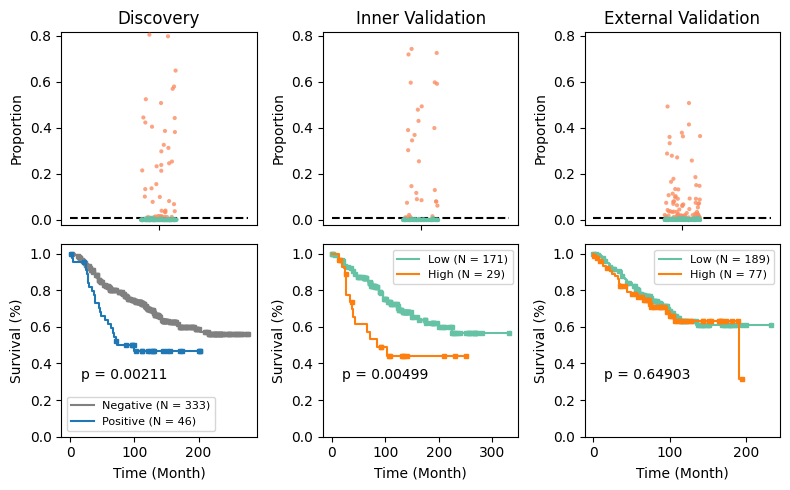

S2: 
0.01


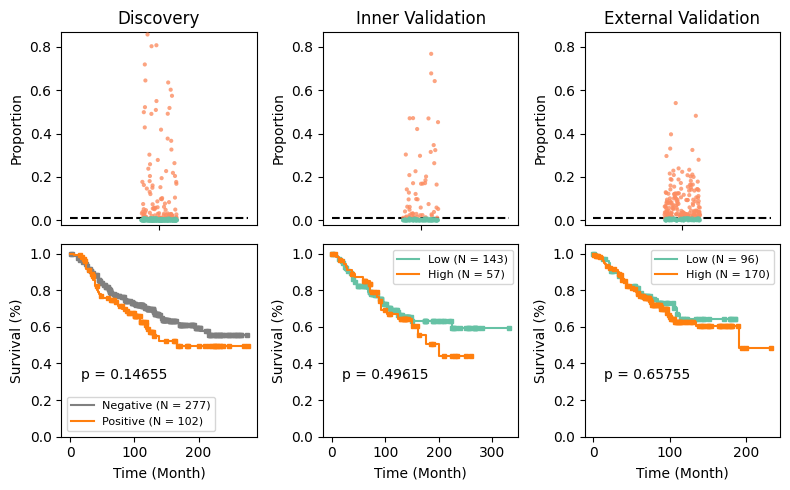

S3: 
0.01


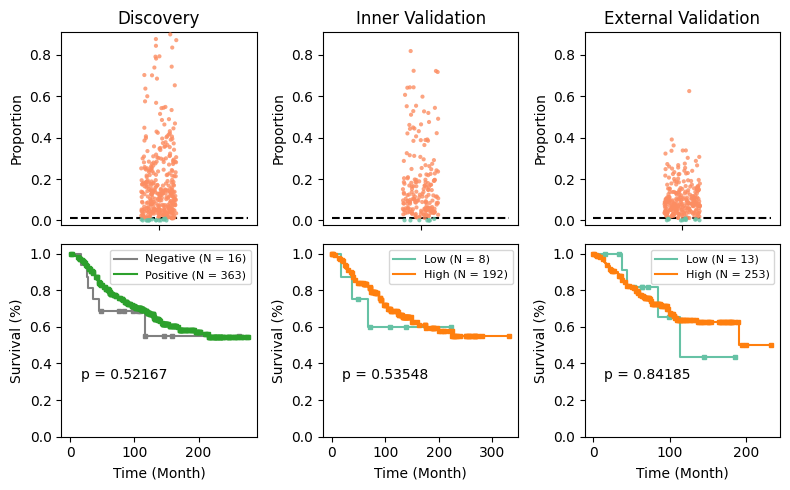

S4: 
0.01


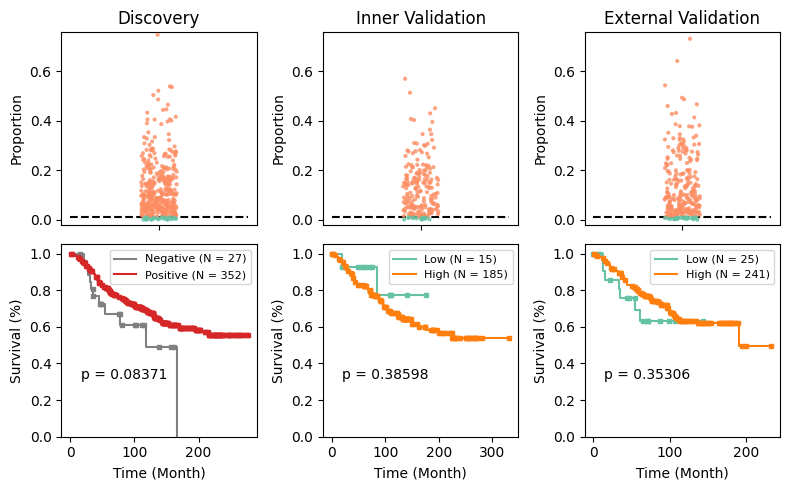

S5: 
0.01


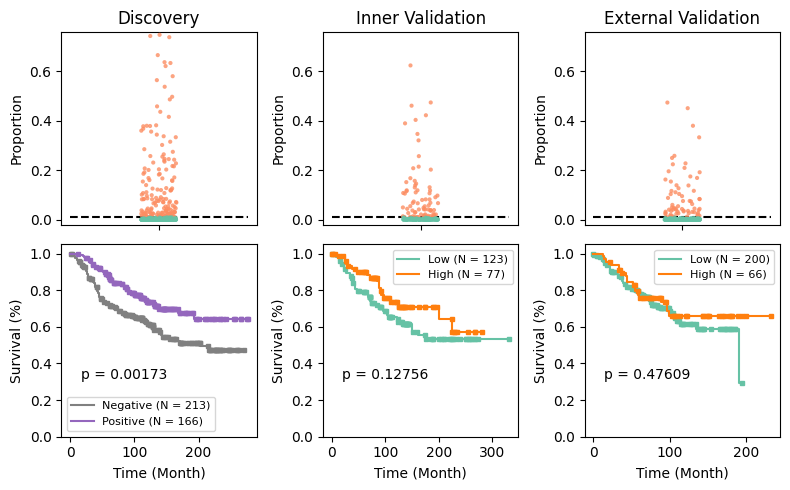

S6: 
0.01


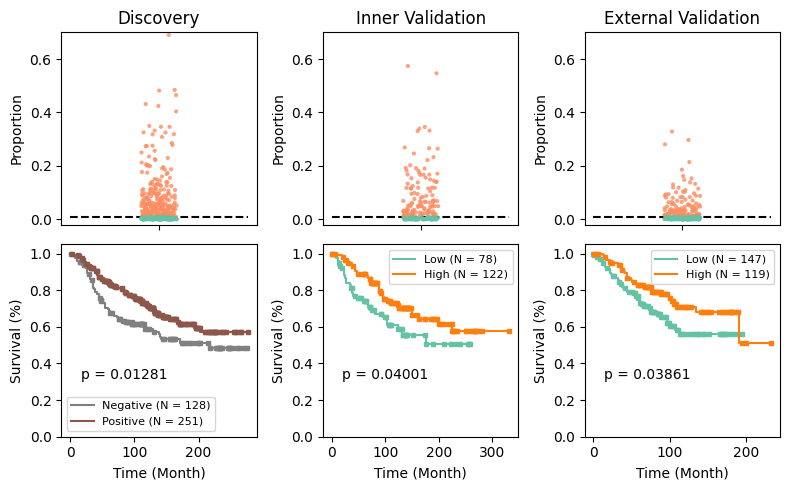

S7: 
0.01


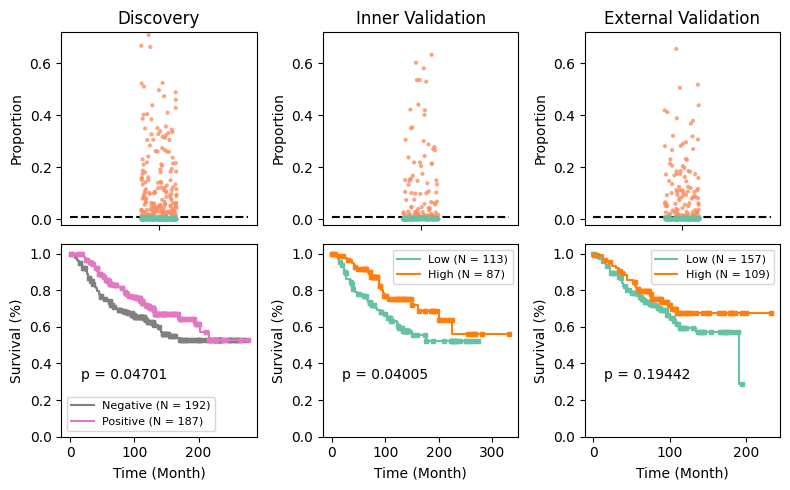

In [25]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    if subgroup_id not in [1,2,3,4,5,6,7]:
        continue
    print("S{}: ".format(subgroup_id))
    # for pattern_id in Candidates:
    if True:
        f, ax  = plt.subplots(2,3, figsize=(8,5), tight_layout=True)
        histogram = Histograms_[:, np.array(Candidates)].sum(axis = 1)
        threshold =  0.01
        print(threshold)
        max_value = np.max(histogram)

        DF = pd.DataFrame({"Proportion": histogram[histogram > threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,0],
            alpha=0.8,
            color=sns.color_palette("Set2")[1],
            label="High",
            size=3,
        )   
        DF = pd.DataFrame({"Proportion": histogram[histogram <= threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,0],
            alpha=0.8,
            color=sns.color_palette("Set2")[0],
            label="Low",
            size=3,
        )

        kmf = KaplanMeierFitter()
        kmf.fit(Length_[histogram <= threshold], Status_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram < threshold)), )
        kmf.plot_survival_function(ax=ax[1,0], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = 'grey')
        kmf.fit(Length_[(histogram > threshold)], Status_[(histogram > threshold)], label='Positive (N = {})'.format(np.sum((histogram >= threshold))))
        kmf.plot_survival_function(ax=ax[1,0], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = color_palette[subgroup_id - 1])
        test = logrank_test(Length_[histogram <= threshold], Length_[(histogram > threshold)], Status_[histogram <= threshold], Status_[(histogram > threshold)])
        ax[1,0].text(0.1, 0.3,"p = {:.5f}".format(test.p_value), fontsize = 10, transform=ax[1,0].transAxes)
        ax[1,0].set(ylim = [0,1.05] , xlabel = 'Time (Month)', ylabel = 'Survival (%)')
        ax[1,0].legend(fontsize = 8)
        ax[0,0].set(ylim = [-0.01, max_value+0.05])

        histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis = 1)
        

        DF = pd.DataFrame({"Proportion": histogram[histogram > threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,1],
            alpha=0.8,
            color=sns.color_palette("Set2")[1],
            label="High",
            size=3,
        )
        DF = pd.DataFrame({"Proportion": histogram[histogram <= threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,1],
            alpha=0.8,
            color=sns.color_palette("Set2")[0],
            label="Low",
            size=3,
        )
        kmf = KaplanMeierFitter()
        kmf.fit(Length_cohort2_[histogram <= threshold], Status_cohort2_[histogram <= threshold], label='Low (N = {})'.format(np.sum(histogram <= threshold)), )
        kmf.plot_survival_function(ax=ax[1,1], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = sns.color_palette("Set2")[0])
        kmf.fit(Length_cohort2_[(histogram > threshold)], Status_cohort2_[(histogram > threshold)], label='High (N = {})'.format(np.sum((histogram > threshold))))
        kmf.plot_survival_function(ax=ax[1,1], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})
        test = logrank_test(Length_cohort2_[histogram <= threshold], Length_cohort2_[(histogram > threshold)], Status_cohort2_[histogram <= threshold], Status_cohort2_[(histogram > threshold)])
        ax[1,1].text(0.1, 0.3,"p = {:.5f}".format(test.p_value), fontsize = 10, transform=ax[1,1].transAxes)
        ax[1,1].set(ylim = [0,1.05] , xlabel = 'Time (Month)', ylabel = 'Survival (%)')
        ax[1,1].legend(fontsize = 8)
        ax[0,1].set(ylim = [-0.02, max_value+0.01])


        histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis = 1)

        DF = pd.DataFrame({"Proportion": histogram[histogram > threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,2],
            alpha=0.8,
            color=sns.color_palette("Set2")[1],
            label="High",
            size=3,
        )
        DF = pd.DataFrame({"Proportion": histogram[histogram <= threshold]})
        sns.stripplot(
            data=DF,
            y="Proportion",
            ax=ax[0,2],
            alpha=0.8,
            color=sns.color_palette("Set2")[0],
            label="Low",
            size=3,
        )

        kmf = KaplanMeierFitter()
        kmf.fit(Length_jackson_[histogram <= threshold], Status_jackson_[histogram <= threshold], label='Low (N = {})'.format(np.sum(histogram <= threshold)), )
        kmf.plot_survival_function(ax=ax[1,2], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = sns.color_palette("Set2")[0])
        kmf.fit(Length_jackson_[(histogram > threshold)], Status_jackson_[(histogram > threshold)], label='High (N = {})'.format(np.sum((histogram > threshold))))
        kmf.plot_survival_function(ax=ax[1,2], ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})
        test = logrank_test(Length_jackson_[histogram <= threshold], Length_jackson_[(histogram > threshold)], Status_jackson_[histogram <= threshold], Status_jackson_[(histogram > threshold)])
        ax[1,2].text(0.1, 0.3,"p = {:.5f}".format(test.p_value), fontsize = 10, transform=ax[1,2].transAxes)
        ax[1,2].set(ylim = [0,1.05] , xlabel = 'Time (Month)', ylabel = 'Survival (%)')
        ax[1,2].legend(fontsize = 8)
        


        ax[0,0].hlines(
            threshold,
            -0.5,
            0.5,
            color="k",
            linestyle="--",
        )
        ax[0,1].hlines(
            threshold,
            -0.5,
            0.5,
            color="k",
            linestyle="--",
        )
        ax[0,2].hlines(
            threshold,
            -0.5,
            0.5,
            color="k",
            linestyle="--",
        )
        ax[0,2].set(ylim = [-0.02, max_value+0.01])
        ax[0,0].set(ylim = [-0.02, max_value+0.01])
        ax[0,1].set(ylim = [-0.02, max_value+0.01])
        ax[0,0].set(title = 'Discovery')
        ax[0,1].set(title = 'Inner Validation')
        ax[0,2].set(title = 'External Validation')
        plt.show()
        



S1: 


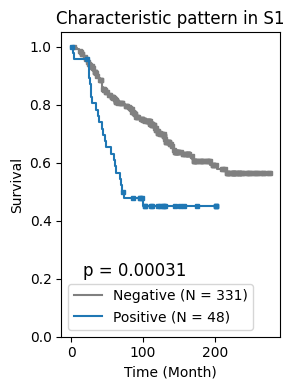

S2: 


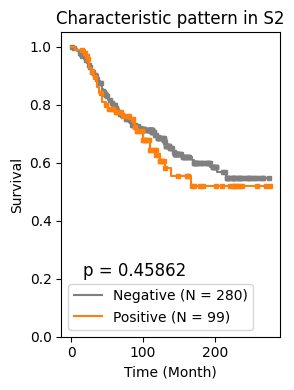

S3: 


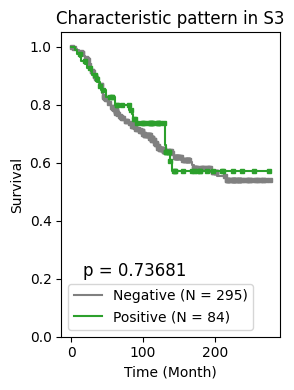

S4: 


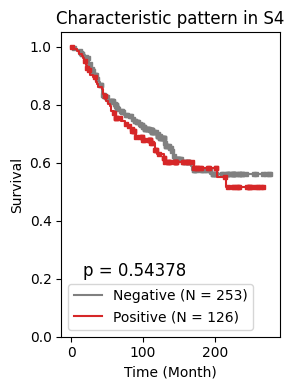

S5: 


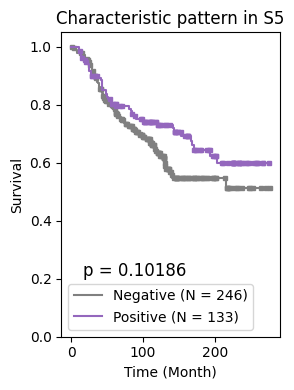

S6: 


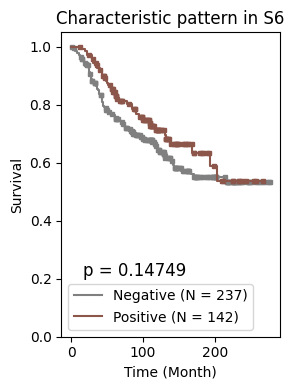

S7: 


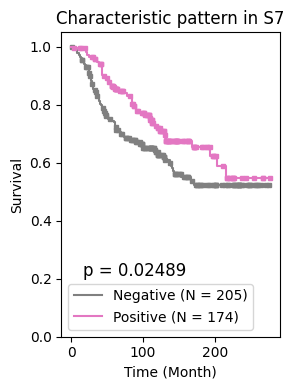

In [16]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    if subgroup_id not in [1,2,3,4,5,6,7]:
        continue
    print("S{}: ".format(subgroup_id))
    # for pattern_id in Candidates:
    if True:
        f, ax  = plt.subplots( figsize=(3,4), tight_layout=True)
        histogram = Histograms_[:, np.array(Candidates)].sum(axis = 1)
        threshold =  0.01
        kmf = KaplanMeierFitter()
        kmf.fit(Length_[histogram < threshold], Status_[histogram < threshold], label='Negative (N = {})'.format(np.sum(histogram < threshold)), )
        kmf.plot_survival_function(ax=ax, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = 'grey')
        kmf.fit(Length_[(histogram >= threshold)], Status_[(histogram >= threshold)], label='Positive (N = {})'.format(np.sum((histogram >= threshold))))
        kmf.plot_survival_function(ax=ax, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"}, color = color_palette[subgroup_id - 1])
        test = logrank_test(Length_[histogram <= threshold], Length_[(histogram > threshold)], Status_[histogram <= threshold], Status_[(histogram > threshold)])
        ax.text(0.1, 0.2,"p = {:.5f}".format(test.p_value), fontsize = 12, transform=ax.transAxes)
        ax.set(ylim = [0,1.05] , xlabel = 'Time (Month)', ylabel = 'Survival')
        ax.legend(fontsize = 10)
        ax.set_title("Characteristic pattern in S{}".format(subgroup_id), fontsize = 12)
   

        # ax.set(title = 'Discovery')
        # ax.set(title = 'Inner Validation')
        # ax.set(title = 'External Validation')
        plt.show()
        



S1: 


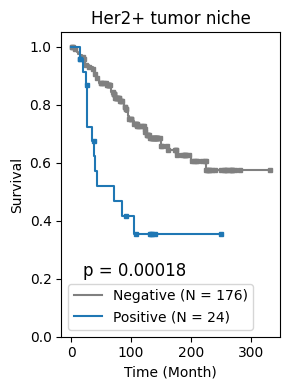

S2: 


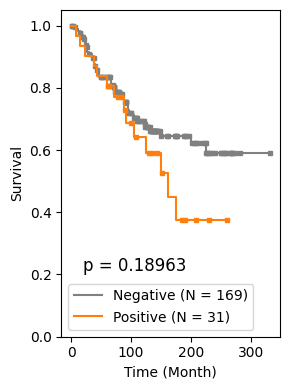

S3: 


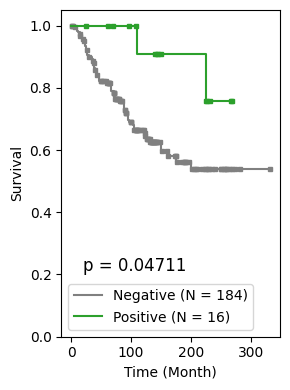

S4: 


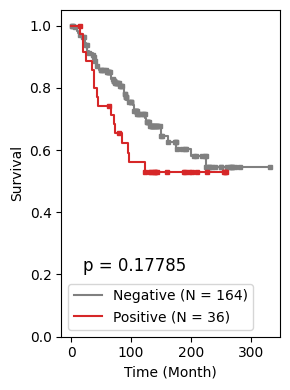

S5: 


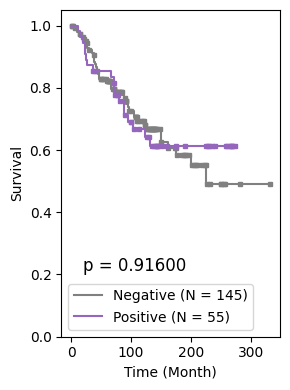

S6: 


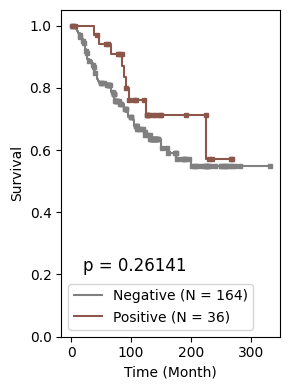

S7: 


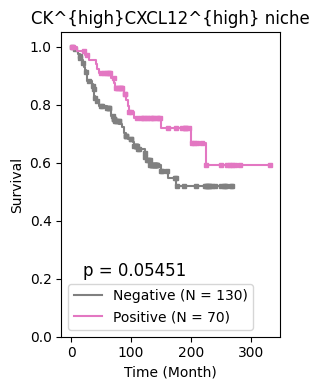

In [22]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    if subgroup_id not in [1, 2, 3, 4, 5, 6, 7]:
        continue
    print("S{}: ".format(subgroup_id))
    # for pattern_id in Candidates:
    if True:
        f, ax = plt.subplots(figsize=(3, 4), tight_layout=True)
        histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
        threshold = 0.01
        kmf = KaplanMeierFitter()
        kmf.fit(
            Length_cohort2_[histogram < threshold],
            Status_cohort2_[histogram < threshold],
            label="Negative (N = {})".format(np.sum(histogram < threshold)),
        )
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
            color="grey",
        )
        kmf.fit(
            Length_cohort2_[(histogram >= threshold)],
            Status_cohort2_[(histogram >= threshold)],
            label="Positive (N = {})".format(np.sum((histogram >= threshold))),
        )
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
            color=color_palette[subgroup_id - 1],
        )
        test = logrank_test(
            Length_cohort2_[histogram <= threshold],
            Length_cohort2_[(histogram > threshold)],
            Status_cohort2_[histogram <= threshold],
            Status_cohort2_[(histogram > threshold)],
        )
        ax.text(
            0.1,
            0.2,
            "p = {:.5f}".format(test.p_value),
            fontsize=12,
            transform=ax.transAxes,
        )
        ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
        ax.legend(fontsize=10)
        if subgroup_id == 1:
            ax.set_title("Her2+ tumor niche", fontsize=12)
        elif subgroup_id == 7:
            ax.set_title("CK^{high}CXCL12^{high} niche", fontsize=12)

        # ax.set(title = 'Discovery')
        # ax.set(title = 'Inner Validation')
        # ax.set(title = 'External Validation')
        plt.show()

S1: 


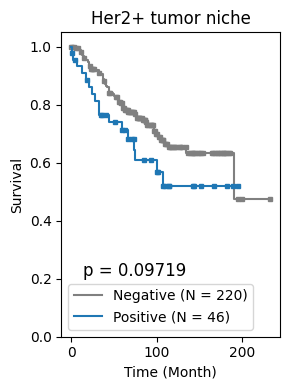

S2: 


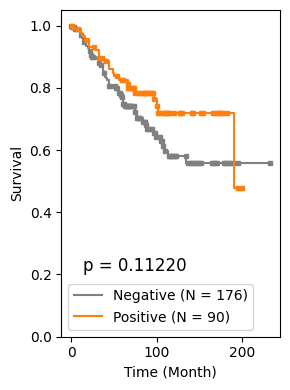

S3: 


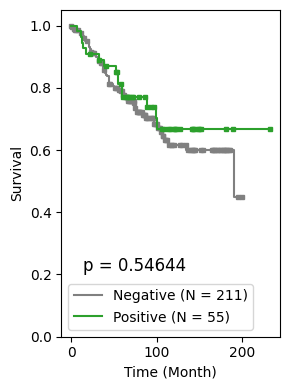

S4: 


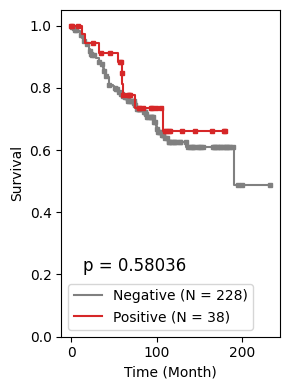

S5: 


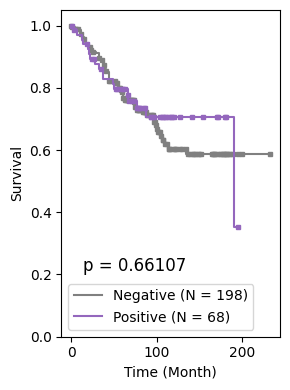

S6: 


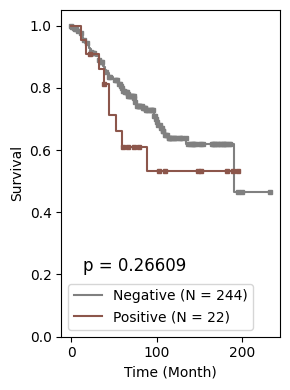

S7: 


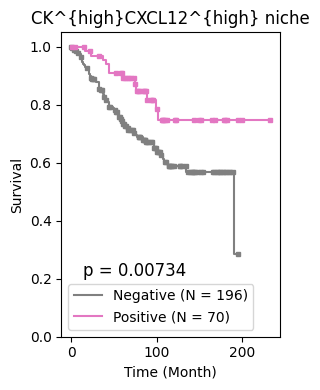

In [24]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    if subgroup_id not in [1, 2, 3, 4, 5, 6, 7]:
        continue
    print("S{}: ".format(subgroup_id))
    # for pattern_id in Candidates:
    if True:
        f, ax = plt.subplots(figsize=(3, 4), tight_layout=True)
        histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
        threshold = 0.01
        kmf = KaplanMeierFitter()
        kmf.fit(
            Length_jackson_[histogram < threshold],
            Status_jackson_[histogram < threshold],
            label="Negative (N = {})".format(np.sum(histogram < threshold)),
        )
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
            color="grey",
        )
        kmf.fit(
            Length_jackson_[(histogram >= threshold)],
            Status_jackson_[(histogram >= threshold)],
            label="Positive (N = {})".format(np.sum((histogram >= threshold))),
        )
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
            color=color_palette[subgroup_id - 1],
        )
        test = logrank_test(
            Length_jackson_[histogram <= threshold],
            Length_jackson_[(histogram > threshold)],
            Status_jackson_[histogram <= threshold],
            Status_jackson_[(histogram > threshold)],
        )
        ax.text(
            0.1,
            0.2,
            "p = {:.5f}".format(test.p_value),
            fontsize=12,
            transform=ax.transAxes,
        )
        ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
        ax.legend(fontsize=10)
        if subgroup_id == 1:
            ax.set_title("Her2+ tumor niche", fontsize=12)
        elif subgroup_id == 7:
            ax.set_title("CK^{high}CXCL12^{high} niche", fontsize=12)

        # ax.set(title = 'Discovery')
        # ax.set(title = 'Inner Validation')
        # ax.set(title = 'External Validation')
        plt.show()

### Plot overpresented patterns

#### Signature map

1 [16]


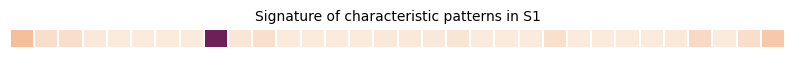

2 [10]


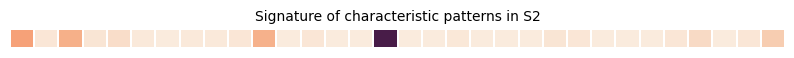

3 [4]


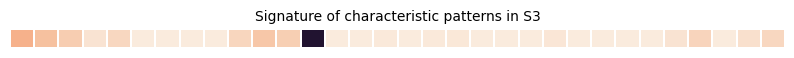

4 [0]


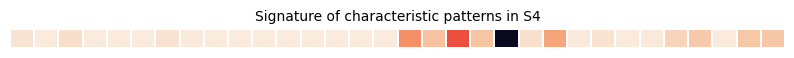

5 [14]


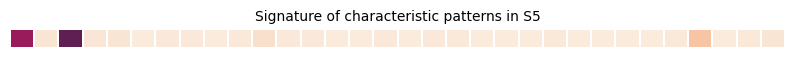

6 [2]


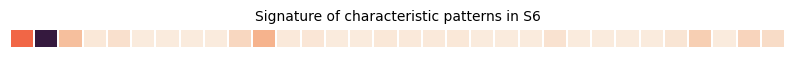

7 [12 21 26]


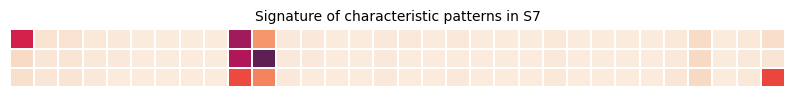

In [63]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_node_id
from utils import reverse_dict

# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(

        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i
    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(Centroids.shape[1])]

for subgroup_id, Candidates in Overpresented_patterns.items():
    if len(Candidates) ==0:
        continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(Candidates)))
    print(subgroup_id, Candidates)
    sns.heatmap(
            Signature[:, np.array(Candidates)].T,
            ax=ax,
            cbar=False,
            cmap="rocket_r",
            linewidth=0.005,
            # edgecolor="black",
            vmax=np.percentile(Signature, 99),
            vmin=np.percentile(Signature, 1),

        )
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    # ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
    # ax.set_yticklabels([i+1 for i in np.array(Candidates)], fontsize=10)
    # ax.set_ylabel("TME pattern index", fontsize=10)
    ax.set(xlabel = 'Cell type')
    ax.set_title(f"Signature of characteristic patterns in S{subgroup_id}", fontsize=10)
    plt.show()



#### Representative examples

0.7879360035624359 5.006855149851049
3.1444062198247593 -2.822730687060357
-0.747185525799182 1.8100647954244096
-4.455376727624298 0.7166588933142748
0.3585571607629845 5.3570001839038355
-1.8899710919529866 3.3997272766900437
1.9578539855344275 -0.7132227526717543
2.730459531112267 -4.557206914567814
8.340345568079442 3.3931725448990164


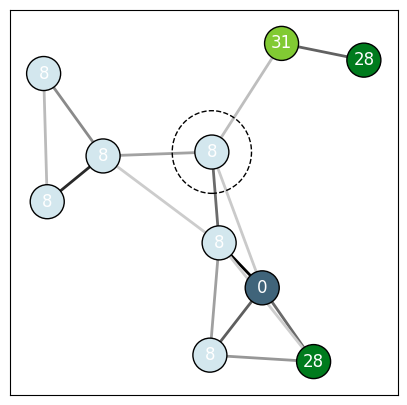

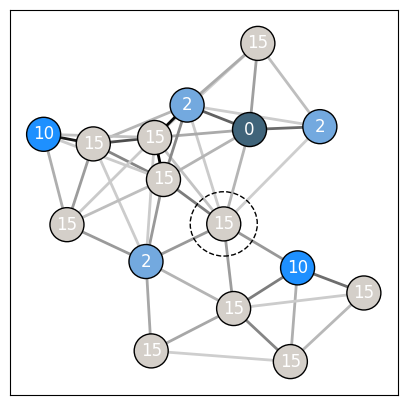

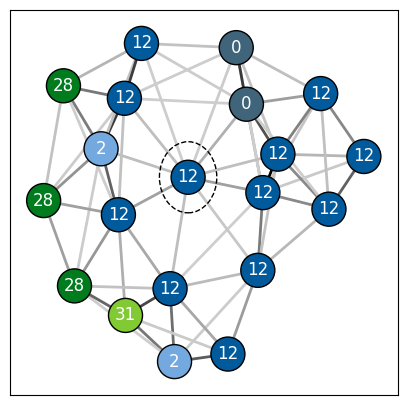

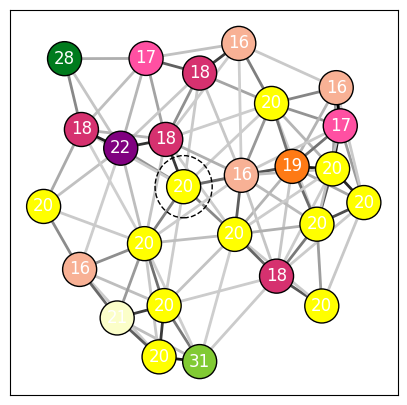

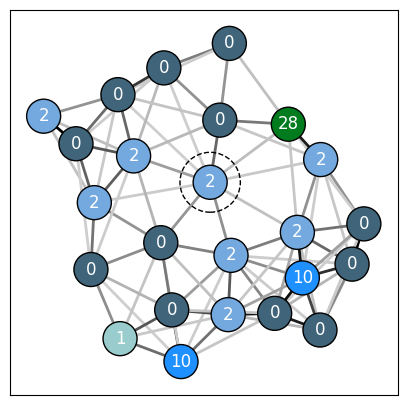

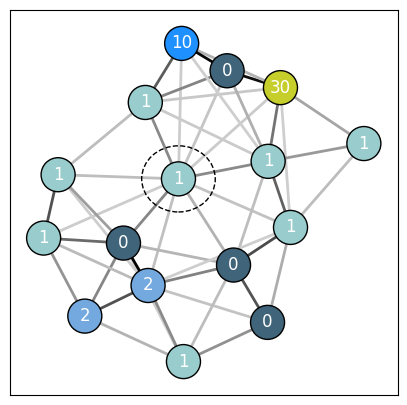

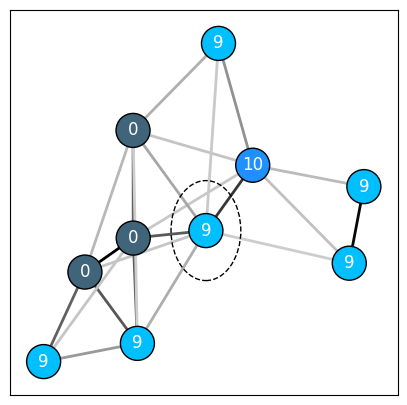

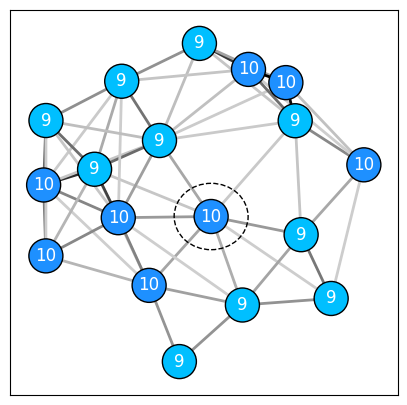

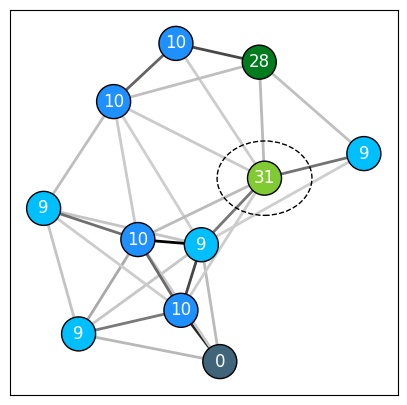

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


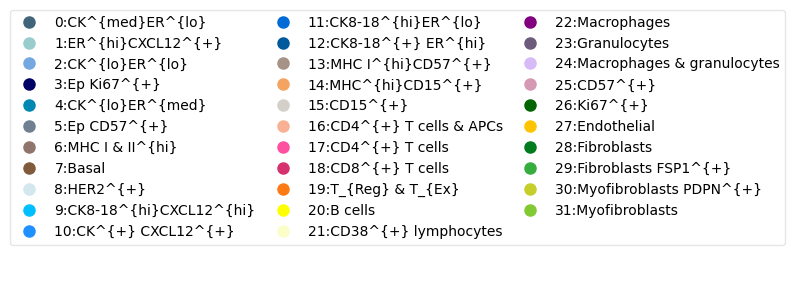

In [64]:
import matplotlib as mpl
from definitions import get_node_id, get_node_color
from utils import reverse_dict
from overpresented_patterns import (
    find_representative_examples,
    decide_subtree_boundary,
    construct_cellular_graph,
)


def get_pos(G):
    x = nx.get_node_attributes(G, "X")
    y = nx.get_node_attributes(G, "Y")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos


def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - np.mean(x)
    y = y - np.mean(y)
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized


Example_ids = {1: [3], 2: [14], 3: [3], 4: [3], 5: [6], 6: [2], 7: [5, 17, 1]}
for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_index in range(len(Candidates)):
        pattern_id = Candidates[pattern_index]
        Examples = find_representative_examples(
            pattern_id,
            Centroids,
            FILE_NAMES,
            X,
            Cluster_identities,
            Indices,
            num_examples=20,
        )
        example_ids = Example_ids[subgroup_id][pattern_index]
        for example_id in [example_ids]:
            patient_id, image_id, subtree_root_idx = Examples[example_id]
            cells_ = pd.read_csv(
                os.path.join(
                    PROJECT_ROOT,
                    "Input",
                    "Single-cell",
                    "Danenberg",
                    "patient_{}_image_{}.csv".format(patient_id, image_id),
                )
            )
            Adj = np.load(
                os.path.join(
                    PROJECT_ROOT,
                    "Output",
                    "a_Cellular_graph_random_split",
                    "Danenberg",
                    "Subset_1",
                    "patient_{}_image_{}".format(patient_id, image_id),
                    "Adj.npy",
                )
            )
            cell_type_ids = np.load(
                os.path.join(
                    PROJECT_ROOT,
                    "Output",
                    "a_Cellular_graph_random_split",
                    "Danenberg",
                    "Subset_1",
                    "patient_{}_image_{}".format(patient_id, image_id),
                    node_label + ".npy",
                )
            )
            subtree_leaf_indices = decide_subtree_boundary(
                subtree_root_idx, Adj, iteration, boundary_weight_threshold=0.1
            )
            cell_types = [
                reverse_dict(get_node_id("Danenberg", node_label))[i]
                for i in cell_type_ids
            ]
            cell_type_colors = [
                get_node_color("Danenberg", node_label)[i] for i in cell_types
            ]
            cellular_graph = construct_cellular_graph(
                Adj,
                cells_,
                cell_types,
                cell_type_ids,
                cell_type_colors,
                edges_visible=0.01,
            )
            subtree_graph = nx.subgraph(cellular_graph, subtree_leaf_indices)
            edge_list = list(subtree_graph.edges())
            edge_alpha = [
                10*subtree_graph[u][v]["weight"]
                if subtree_graph[u][v]["weight"] > 0.01
                else 0
                for u, v in edge_list
            ]
            edge_alpha = np.array(edge_alpha)

            import matplotlib.colors as mcolors
            cmap_greys = plt.get_cmap("Greys")
            start_point = 0.3
            end_point = 1.0
            new_cmap_colors = cmap_greys(np.linspace(start_point, end_point, 256))
            new_cmap = mcolors.LinearSegmentedColormap.from_list("Greys_RightHalf", new_cmap_colors)

            # edge_alpha[edge_alpha<np.percentile(edge_alpha, 50)] = np.percentile(edge_alpha, 50)
            # print(np.sort(  edge_alpha))
            # edge_alpha[edge_alpha<np.percentile(edge_alpha, 90)] = np.percentile(edge_alpha, 90)
            f, ax = plt.subplots(figsize=(5, 5))
            node_color = [
                value
                for key, value in nx.get_node_attributes(
                    subtree_graph, "cell_type_color"
                ).items()
            ]
            print(
                normalize_pos(get_pos(subtree_graph))[subtree_root_idx][0],
                normalize_pos(get_pos(subtree_graph))[subtree_root_idx][1],
            )
            circle = plt.Circle(
                (
                    normalize_pos(get_pos(subtree_graph))[subtree_root_idx][0],
                    normalize_pos(get_pos(subtree_graph))[subtree_root_idx][1],
                ),
                5,
                color="k",
                fill=False,
                linestyle="--",
            )
            
            nx.draw_networkx(
                subtree_graph,
                normalize_pos(get_pos(subtree_graph)),
                node_size=600,
                node_color=node_color,
                labels=nx.get_node_attributes(subtree_graph, "cell_type_id"),
                font_color="white",
                with_labels=True,
                edgecolors="k",
                ax=ax,
                edge_color=edge_alpha,
                edge_cmap=new_cmap,
                width=2,
            )
            ax.add_patch(circle)
            # ax.set(xlim=(-40, 40), ylim=(-40, 40))
            # ax.set_title(
            #     "Pattern {} over-presented in S{}, example {}".format(
            #         pattern_id + 1, subgroup_id, example_id
            #     )
            # )
# Print Legend
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [
    str(i) + ":" + reverse_dict(get_node_id("Danenberg", node_label))[i]
    for i in range(len(get_node_id("Danenberg", node_label)))
]
handles = [
    func("o", get_node_color("Danenberg", node_label)[i.split(":")[1]])
    for i in cell_types
]
ax.legend(
    handles,
    cell_types,
    loc=3,
    framealpha=0.5,
    frameon=1,
    ncols=3,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    mode="expand",
    borderaxespad=0.0,
    fontsize=10,
)
ax.axis("off")
plt.show()

In [84]:
def best_thresholds(histogram, subgroup_id):
    label = Subgroup_ids_ == subgroup_id
    Thresholds = np.linspace(0, 1, 100)
    Accuracy = []
    for threshold in Thresholds:
        label_ = histogram > threshold
        Accuracy.append(np.sum(label == label_) / len(label))
    Accuracy = np.array(Accuracy)
    return Thresholds[np.argmax(Accuracy)]
        
        


In [79]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
# clinical = process_Danenberg_clinical_data(clinical)
clinical['ERStatus'] = clinical['ERStatus'].map({
    'pos': 1,
    'neg': 0,
})
clinical['HER2Status'] = clinical['ERBB2_pos'].map(
    {False:0,
    True:1,}
)


ERStatus = [clinical.loc[clinical['patient_id'] == patient_id, 'ERStatus'].values[0] for patient_id in Patient_IDs_]
HER2Status = [clinical.loc[clinical['patient_id'] == patient_id, 'HER2Status'].values[0] for patient_id in Patient_IDs_]
Age = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs_]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs_]
clinical.head()

,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id,HER2Status
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2,0.0
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2,0.0
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1,0.0
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1,0.0
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1,0.0


In [86]:
test_metric = 'existence'
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
    'ERStatus': ERStatus,
    'HER2Status': HER2Status,
    'Age': Age,
    'Grade': Grade,
})


Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += 1


pattern_id = 0
i = 0
for name, Candidates in Overpresented_patterns.items():
    # for pattern_id in Candidates:
    if True:
        yticklabels =[name]
        histogram = Histograms_[:, np.array(Candidates)].sum(axis = 1)

        if test_metric == 'normalized proportion':
            DF['CP_S'+str(name)] = (histogram - np.mean(histogram_ref))/np.std(histogram_ref)
        elif test_metric == 'proportion':
            DF['CP_S'+str(name)] = histogram 
        elif test_metric == 'existence':
            DF['CP_S'+str(name)] = histogram > 0.01
        elif test_metric == 'binary':
            threshold = best_thresholds(histogram, name)
            print(threshold)
            if np.sum(histogram > threshold) == 0:
                continue
            DF['CP_S'+str(name)] = histogram > threshold

    i+=1
    pattern_id+=1

DF = DF.fillna(0)
print(len(DF))    


cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'ERStatus + HER2Status')
# print(cph.summary['Concordance'])
cph.print_summary()
# cph.plot()

cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'Age + Grade')
cph.print_summary()
# cph.plot()


cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'ERStatus + HER2Status + Age + Grade')
cph.print_summary()

cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'CP_S1 + CP_S2 + CP_S3 + CP_S4 + CP_S5 + CP_S6 + CP_S7')
cph.print_summary()
# cph.plot()

cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'ERStatus + HER2Status + CP_S1 + CP_S2 + CP_S3 + CP_S4 + CP_S5 + CP_S6 + CP_S7')
cph.print_summary()

cph = CoxPHFitter(penalizer=0.00)
cph.fit(DF, duration_col='length', event_col='status', formula = 'ERStatus + HER2Status + Age + Grade + CP_S1 + CP_S2 + CP_S3 + CP_S4 + CP_S5 + CP_S6 + CP_S7')
cph.print_summary()
# cph.plot()


# f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(8, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
# pattern_id = 0
# i = 0
# for name, Candidates in Overpresented_patterns.items():    
#     cph = CoxPHFitter(penalizer=0.00)
#     cph.fit(DF, duration_col='length', event_col='status', formula = 'ERStatus + HER2Status + CP_S'+str(name))
#     # cph.print_summary()
#     # cph.plot()

#     yticklabels =[name]
#     hr = cph.hazard_ratios_['CP_S'+str(name)]
#     hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]['CP_S'+str(name)])
#     hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]['CP_S'+str(name)])
#     p = cph.summary["p"]['CP_S'+str(name)]
#     print("Pattern {}: hr = {}, p = {}".format(pattern_id+1, hr, p))
#     if p < 0.05/Num_patterns_to_test:
#         color = 'k'
#     else:
#         color = 'grey'
        
#     if Num_patterns_to_test == 1:
#         ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax.scatter([hr], [0], color = color, s=120)
#         ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax.set_yticks([0])
#         ax.set_yticklabels(yticklabels)
#         ax.get_yticklabels()[0].set_color(color)
#         ax.vlines(1, -1, 1, color="grey", linestyle="--")
#     else:
#         ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax[i].scatter([hr], [0], color = color, s=120)
#         ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax[i].set_yticks([0])
#         ax[i].set_yticklabels(yticklabels)
#         ax[i].get_yticklabels()[0].set_color(color)
#         ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
#     i+=1
#     pattern_id+=1


# if Num_patterns_to_test == 1:
#     ax.set_xlabel("Hazard ratio (95% CI)")
# else:
#     ax[i-1].set_xlabel("Hazard ratio (95% CI)")

379


<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -694.12
         time fit was run = 2024-01-03 16:59:52 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
ERStatus    -0.40       0.67       0.20            -0.80            -0.00                 0.45                 1.00
HER2Status   0.95       2.58       0.26             0.44             1.45                 1.56                 4.26

             cmp to     z      p   -log2(p)
covariate                                  
ERStatus       0.00 -1.96   0.05       4.33
HER2Status     0.00  3.69 <0.005      12.13
---
Concordance = 0.59
Partial AIC = 1392.25
log-likelihood ratio test = 17.43 on 2 df
-log2(p) of ll-ratio test = 12.57

<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -683.58
         time fit was run = 2024-01-03 16:59:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Age         0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
Grade       0.84       2.32       0.16             0.53             1.16                 1.70                 3.18

            cmp to    z      p   -log2(p)
covariate                                
Age           0.00 1.99   0.05       4.41
Grade         0.00 5.27 <0.005      22.82
---
Concordance = 0.68
Partial AIC = 1371.16
log-likelihood ratio test = 38.52 on 2 df
-log2(p) of ll-ratio test = 27.78

<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -679.41
         time fit was run = 2024-01-03 16:59:52 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Age          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
ERStatus    -0.25       0.78       0.21            -0.66             0.16                 0.52                 1.18
Grade        0.73       2.07       0.16             0.41             1.05                 1.50                 2.86
HER2Status   0.69       1.98       0.26             0.18             1.19                 1.19                 3.30

             cmp to     z      p   -log2(p)
covariate                                  
Age            0.00  2.10   0.04       4.81
ERStatus       0.00 -1.18   0.24       2.08
Grade          0.00  4.45 <0.005      16.81
HER2Status     0.00  2.65   0.01       6.95
---
Concordance = 0.70
Partial AIC = 1366.82
log-likelihood ratio test = 46.86 on 4 df
-log2(p) of ll-ratio test = 29.19

<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -694.64
         time fit was run = 2024-01-03 16:59:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CP_S1       0.67       1.95       0.24             0.20             1.14                 1.22                 3.11
CP_S2       0.19       1.21       0.20            -0.20             0.59                 0.82                 1.80
CP_S3       0.12       1.13       0.24            -0.34             0.59                 0.71                 1.80
CP_S4      -0.05       0.95       0.19            -0.43             0.33                 0.65                 1.39
CP_S5      -0.27       0.77       0.20            -0.66             0.12                 0.52                 1.13
CP_S6      -0.11       0.89       0.21            -0.52             0.30                 0.60                 1.35
CP_S7      -0.31       0.74       0.20            -0.69             0.08                 0.50                 1.08

            cmp to     z    p   -log2(p)
covariate                               
CP_S1         0.00  2.80 0.01       7.62
CP_S2         0.00  0.96 0.34       1.56
CP_S3         0.00  0.51 0.61       0.72
CP_S4         0.00 -0.26 0.80       0.33
CP_S5         0.00 -1.34 0.18       2.47
CP_S6         0.00 -0.53 0.59       0.75
CP_S7         0.00 -1.57 0.12       3.09
---
Concordance = 0.61
Partial AIC = 1403.28
log-likelihood ratio test = 16.39 on 7 df
-log2(p) of ll-ratio test = 5.52

<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -691.85
         time fit was run = 2024-01-03 16:59:52 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
CP_S1        0.37       1.45       0.36            -0.34             1.07                 0.71                 2.93
CP_S2        0.16       1.17       0.20            -0.24             0.56                 0.79                 1.74
CP_S3        0.20       1.23       0.24            -0.27             0.68                 0.76                 1.98
CP_S4       -0.11       0.90       0.20            -0.49             0.28                 0.61                 1.32
CP_S5       -0.24       0.79       0.20            -0.63             0.15                 0.53                 1.17
CP_S6       -0.01       0.99       0.22            -0.44             0.41                 0.64                 1.51
CP_S7       -0.20       0.82       0.20            -0.60             0.21                 0.55                 1.23
ERStatus    -0.41       0.67       0.23            -0.86             0.04                 0.42                 1.05
HER2Status   0.56       1.75       0.40            -0.24             1.35                 0.79                 3.86

             cmp to     z    p   -log2(p)
covariate                                
CP_S1          0.00  1.02 0.31       1.71
CP_S2          0.00  0.79 0.43       1.21
CP_S3          0.00  0.84 0.40       1.32
CP_S4          0.00 -0.54 0.59       0.76
CP_S5          0.00 -1.19 0.24       2.09
CP_S6          0.00 -0.06 0.95       0.08
CP_S7          0.00 -0.96 0.34       1.57
ERStatus       0.00 -1.77 0.08       3.69
HER2Status     0.00  1.38 0.17       2.57
---
Concordance = 0.62
Partial AIC = 1401.69
log-likelihood ratio test = 21.98 on 9 df
-log2(p) of ll-ratio test = 6.80

<lifelines.CoxPHFitter: fitted with 379 total observations, 251 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 379
number of events observed = 128
   partial log-likelihood = -676.29
         time fit was run = 2024-01-03 16:59:52 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Age          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
CP_S1        0.38       1.47       0.37            -0.34             1.11                 0.71                 3.02
CP_S2        0.17       1.19       0.20            -0.23             0.57                 0.80                 1.77
CP_S3        0.22       1.24       0.24            -0.26             0.69                 0.77                 2.00
CP_S4       -0.19       0.82       0.20            -0.58             0.19                 0.56                 1.21
CP_S5       -0.36       0.70       0.20            -0.75             0.03                 0.47                 1.03
CP_S6        0.03       1.04       0.22            -0.40             0.47                 0.67                 1.60
CP_S7       -0.00       1.00       0.21            -0.41             0.40                 0.66                 1.50
ERStatus    -0.35       0.71       0.24            -0.83             0.13                 0.44                 1.14
Grade        0.77       2.15       0.17             0.43             1.10                 1.54                 3.00
HER2Status   0.32       1.38       0.40            -0.46             1.11                 0.63                 3.05

             cmp to     z      p   -log2(p)
covariate                                  
Age            0.00  2.31   0.02       5.57
CP_S1          0.00  1.05   0.30       1.76
CP_S2          0.00  0.84   0.40       1.32
CP_S3          0.00  0.90   0.37       1.44
CP_S4          0.00 -0.99   0.32       1.63
CP_S5          0.00 -1.82   0.07       3.88
CP_S6          0.00  0.16   0.88       0.19
CP_S7          0.00 -0.02   0.98       0.03
ERStatus       0.00 -1.42   0.15       2.69
Grade          0.00  4.52 <0.005      17.32
HER2Status     0.00  0.81   0.42       1.25
---
Concordance = 0.70
Partial AIC = 1374.58
log-likelihood ratio test = 53.09 on 11 df
-log2(p) of ll-ratio test = 22.46

In [ ]:
ERStatus + HER2Status: 0.59
CP: 0.61
ERStatus + HER2Status + CP: 0.62
Age + Grade: 0.68
Age + Grade + ERStatus + HER2Status: 0.70
Age + Grade + ERStatus + HER2Status + CP: 0.70

0.11111111111111112
0.09090909090909091
0.16161616161616163
0.09090909090909091
0.07070707070707072
0.12121212121212122
0.030303030303030304
0.010101010101010102
0.010101010101010102


<lifelines.CoxPHFitter: fitted with 200 total observations, 136 right-censored observations>
             duration col = 'length'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 200
number of events observed = 64
   partial log-likelihood = -303.91
         time fit was run = 2024-01-02 21:48:07 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
pattern_17_S1   0.42       1.52       0.41            -0.38             1.22                 0.68                 3.38
pattern_11_S2  -2.44       0.09       3.13            -8.58             3.69                 0.00                40.21
pattern_5_S3   -0.92       0.40       0.96            -2.81             0.97                 0.06                 2.64
pattern_1_S4    0.51       1.66       0.38            -0.24             1.26                 0.78                 3.51
pattern_15_S5  -0.34       0.71       0.58            -1.49             0.80                 0.23                 2.23
pattern_3_S6   -0.47       0.63       0.98            -2.39             1.45                 0.09                 4.27
pattern_13_S7   0.65       1.92       0.50            -0.33             1.63                 0.72                 5.10
pattern_22_S7  -0.55       0.57       0.43            -1.39             0.28                 0.25                 1.32
pattern_27_S7   0.05       1.05       0.48            -0.89             0.99                 0.41                 2.68

                cmp to     z    p   -log2(p)
covariate                                   
pattern_17_S1     0.00  1.03 0.30       1.72
pattern_11_S2     0.00 -0.78 0.44       1.20
pattern_5_S3      0.00 -0.95 0.34       1.56
pattern_1_S4      0.00  1.32 0.19       2.42
pattern_15_S5     0.00 -0.59 0.56       0.85
pattern_3_S6      0.00 -0.48 0.63       0.66
pattern_13_S7     0.00  1.31 0.19       2.38
pattern_22_S7     0.00 -1.30 0.19       2.37
pattern_27_S7     0.00  0.10 0.92       0.12
---
Concordance = 0.61
Partial AIC = 625.83
log-likelihood ratio test = 9.28 on 9 df
-log2(p) of ll-ratio test = 1.28

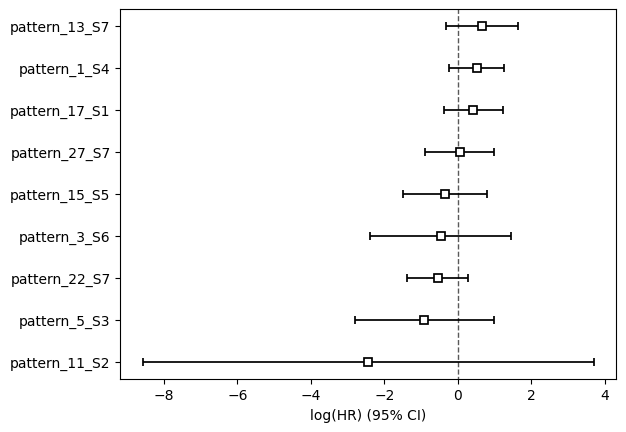

In [102]:

DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
})

Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += 1

# f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(8, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
pattern_id = 0
i = 0
for name, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        yticklabels =[pattern_id]
        histogram = Histograms_cohort2_[:, np.array(pattern_id)]
        histogram_ref = Histograms_[:, np.array(pattern_id)]
        if test_metric == 'normalized proportion':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = (histogram - np.mean(histogram_ref))/np.std(histogram_ref)
        elif test_metric == 'proportion':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram 
        elif test_metric == 'existence':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram > 0
        elif test_metric == 'binary':
            threshold = best_thresholds(histogram_ref, name)
            print(threshold)
            if np.sum(histogram > threshold) == 0:
                continue
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram > threshold

    i+=1
    pattern_id+=1

    
cph = CoxPHFitter(penalizer=0.01)
cph.fit(DF, duration_col='length', event_col='status')
cph.print_summary()
cph.plot()
# pattern_id = 0
# i = 0
# for name, Candidates in Overpresented_patterns.items():    
#     yticklabels =[name]
#     hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
#     hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
#     hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
#     p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
#     print("Pattern {}: hr = {}, p = {}".format(pattern_id+1, hr, p))
#     if p < 0.05/Num_patterns_to_test:
#         color = 'k'
#     else:
#         color = 'grey'
        
#     if Num_patterns_to_test == 1:
#         ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax.scatter([hr], [0], color = color, s=120)
#         ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax.set_yticks([0])
#         ax.set_yticklabels(yticklabels)
#         ax.get_yticklabels()[0].set_color(color)
#         ax.vlines(1, -1, 1, color="grey", linestyle="--")
#     else:
#         ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax[i].scatter([hr], [0], color = color, s=120)
#         ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax[i].set_yticks([0])
#         ax[i].set_yticklabels(yticklabels)
#         ax[i].get_yticklabels()[0].set_color(color)
#         ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
#     i+=1
#     pattern_id+=1


if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")

0.11111111111111112
0.09090909090909091
0.16161616161616163
0.09090909090909091
0.07070707070707072
0.12121212121212122
0.030303030303030304
0.010101010101010102
0.010101010101010102


<lifelines.CoxPHFitter: fitted with 266 total observations, 189 right-censored observations>
             duration col = 'length'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 266
number of events observed = 77
   partial log-likelihood = -384.78
         time fit was run = 2024-01-02 21:48:36 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
pattern_17_S1   1.36       3.90       0.47             0.44             2.28                 1.55                 9.79
pattern_11_S2   0.19       1.21       0.60            -0.98             1.36                 0.37                 3.88
pattern_5_S3    0.05       1.05       0.60            -1.12             1.22                 0.33                 3.37
pattern_1_S4   -2.37       0.09       2.46            -7.19             2.44                 0.00                11.50
pattern_15_S5  -2.57       0.08       2.66            -7.79             2.64                 0.00                14.04
pattern_13_S7  -2.16       0.12       3.27            -8.58             4.25                 0.00                70.45
pattern_22_S7  -0.62       0.54       0.41            -1.42             0.18                 0.24                 1.20
pattern_27_S7  -0.42       0.66       0.48            -1.35             0.52                 0.26                 1.68

                cmp to     z      p   -log2(p)
covariate                                     
pattern_17_S1     0.00  2.90 <0.005       8.06
pattern_11_S2     0.00  0.31   0.75       0.41
pattern_5_S3      0.00  0.08   0.93       0.10
pattern_1_S4      0.00 -0.97   0.33       1.58
pattern_15_S5     0.00 -0.97   0.33       1.58
pattern_13_S7     0.00 -0.66   0.51       0.97
pattern_22_S7     0.00 -1.52   0.13       2.96
pattern_27_S7     0.00 -0.87   0.38       1.38
---
Concordance = 0.62
Partial AIC = 785.57
log-likelihood ratio test = 18.27 on 8 df
-log2(p) of ll-ratio test = 5.70

<AxesSubplot: xlabel='log(HR) (95% CI)'>

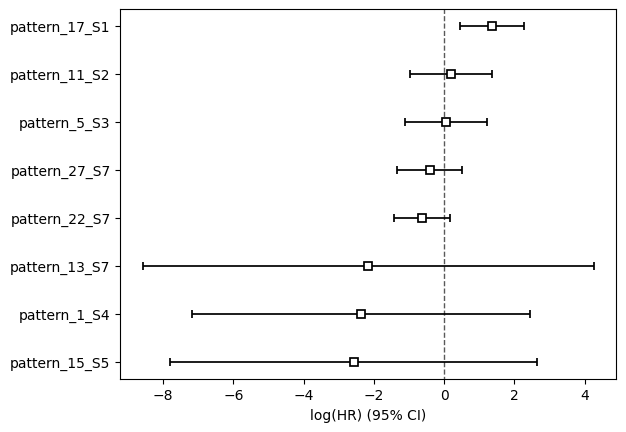

In [103]:

DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += 1

# f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(8, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
pattern_id = 0
i = 0
for name, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        yticklabels =[pattern_id]
        histogram = Histograms_jackson_[:, np.array(pattern_id)]
        histogram_ref = Histograms_[:, np.array(pattern_id)]
        if test_metric == 'normalized proportion':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = (histogram - np.mean(histogram_ref))/np.std(histogram_ref)
        elif test_metric == 'proportion':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram 
        elif test_metric == 'existence':
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram > 0
        elif test_metric == 'binary':
            threshold = best_thresholds(histogram_ref, name)
            print(threshold)
            if np.sum(histogram > threshold) == 0:
                continue
            DF["pattern_"+str(pattern_id+1)+'_S'+str(name)] = histogram > threshold

    i+=1
    pattern_id+=1

    
cph = CoxPHFitter(penalizer=0.01)
cph.fit(DF, duration_col='length', event_col='status')
cph.print_summary()
cph.plot()

# pattern_id = 0
# i = 0
# for name, Candidates in Overpresented_patterns.items():    
#     yticklabels =[name]
#     hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
#     hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
#     hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
#     p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
#     print("Pattern {}: hr = {}, p = {}".format(pattern_id+1, hr, p))
#     if p < 0.05/Num_patterns_to_test:
#         color = 'k'
#     else:
#         color = 'grey'
        
#     if Num_patterns_to_test == 1:
#         ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax.scatter([hr], [0], color = color, s=120)
#         ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax.set_yticks([0])
#         ax.set_yticklabels(yticklabels)
#         ax.get_yticklabels()[0].set_color(color)
#         ax.vlines(1, -1, 1, color="grey", linestyle="--")
#     else:
#         ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
#         ax[i].scatter([hr], [0], color = color, s=120)
#         ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
#         ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
#         ax[i].set_yticks([0])
#         ax[i].set_yticklabels(yticklabels)
#         ax[i].get_yticklabels()[0].set_color(color)
#         ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
#     i+=1
#     pattern_id+=1


# if Num_patterns_to_test == 1:
#     ax.set_xlabel("Hazard ratio (95% CI)")
# else:
#     ax[i-1].set_xlabel("Hazard ratio (95% CI)")